In [714]:
import os
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import cv2

from utils import plot_preds, nms_yv1

# Config

In [715]:
CLASSES = ["airplane"]
COLORS = {"airplane":(0,255,255)}

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

SX = 7
SY = 7
B = 2 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Model

In [716]:
class OPTIM_BED(nn.Module):
    def __init__(self, num_classes, S, B, in_channels=3):
        super(OPTIM_BED, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.S = S
        self.B = B
        
        self.model = self.__create_BED__()

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            # CNNBlock Out
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    def forward(self, x):
        x_out = self.model(x)
        x = x_out.permute(0, 2, 3, 1)
        if self.B == 1:
            x = torch.cat((torch.sigmoid(x[..., 0:5]), x[..., 5:6]), dim=-1)  
        else:
            x = torch.cat((torch.sigmoid(x[..., 0:10]), x[..., 10:11]), dim=-1)
        return x 

In [717]:
model = OPTIM_BED(num_classes=C, S=SX, B=B, in_channels=3)
model_path = './results/'
model_file = model_path + 'bed_best_2BB_mAP.pt'

print(model_file)

checkpoint = torch.load(model_file, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval() 

./results/bed_best_2BB_mAP.pt


OPTIM_BED(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False

# Path and File

In [718]:
ds_dir = '../../../Carlos_Gonzalez/YOLO/Datasets/Airbus_256/'

train_imgs = ds_dir + 'images/train/'
train_labels = ds_dir + 'labels/train/'

val_imgs = ds_dir + 'images/valid/'
val_labels = ds_dir + 'labels/valid/'

test_imgs = ds_dir + 'images/test/'
test_labels = ds_dir + 'labels/test/'

# Load Image and Plot

In [747]:
images_dir = test_imgs
images_list = os.listdir(images_dir)
image = images_list[427]
name = Path(image).stem
img_path = images_dir + name + '.jpg'

print(f'Name: {name}')
print(f'Path: {img_path}')

Name: 20bfce20-fb8a-4e20-a4aa-57064add848b_58
Path: ../../../Carlos_Gonzalez/YOLO/Datasets/Airbus_256/images/test/20bfce20-fb8a-4e20-a4aa-57064add848b_58.jpg


In [748]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
img_draw = img.copy()

# Get Ground Truth BBoxes

In [749]:
def get_gt_boxes(label_path):
    boxes= []   
    with open(label_path) as f:
        lines = f.readlines()
        for l in lines:
            class_id, xc, yc, w, h = l.strip().split(' ')
            class_id = float(class_id)
            box = np.array([xc, yc, w, h]).astype(np.float32)
            boxes.append([box[0], box[1], box[2], box[3], 1, class_id])
    return boxes

labels_dir = test_labels
label_path = labels_dir + name + '.txt'
gt_boxes = get_gt_boxes(label_path)
for box in gt_boxes:
    print(box)

[0.851562, 0.234375, 0.296875, 0.335938, 1, 0.0]
[0.664062, 0.699219, 0.335938, 0.304688, 1, 0.0]


# Original Image with BBoxes

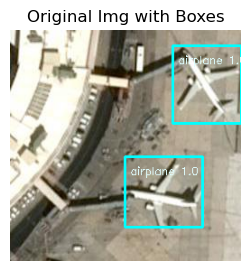

In [750]:
img_boxes = plot_preds(ori_img=img_draw, 
                       img_w=img_draw.shape[1], 
                       img_h=img_draw.shape[0],
                       nms_preds=gt_boxes,
                       names=CLASSES,
                       colors=COLORS)
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title("Original Img with Boxes")
ax.imshow(img_boxes)
ax.set_axis_off()
plt.show()

# Prepare image for inference

In [751]:
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
    ToTensorV2(p=1),
])

img_alb = val_transform(image=img)
img_2_model = img_alb['image']
img_2_model = img_2_model.unsqueeze(0)
print(img_2_model.shape)

torch.Size([1, 3, 224, 224])


# Run inference

In [752]:
out = model(img_2_model)

# Post-process output BBoxes

In [753]:
conf_1 = out[..., 4:5]
conf_2 = out[..., 9:10]
confs = torch.cat((conf_1, conf_2), dim=-1)
_, idx = torch.max(confs, keepdim=True, dim=-1)

best_boxes = idx*out[..., 5:10] + (1-idx)*out[..., 0:5]

_, class_idx = torch.max(out[..., 10:11], keepdim=True, dim=-1)

best_out = torch.cat((best_boxes, class_idx), dim=-1)

In [754]:
best_out.detach()[0]

tensor([[[0.4759, 0.6376, 0.3504, 0.2821, 0.0180, 0.0000],
         [0.4231, 0.6307, 0.4692, 0.3560, 0.0209, 0.0000],
         [0.2166, 0.6292, 0.4819, 0.4158, 0.0187, 0.0000],
         [0.4740, 0.5912, 0.4055, 0.3114, 0.0180, 0.0000],
         [0.3830, 0.5858, 0.3878, 0.2677, 0.0126, 0.0000],
         [0.3958, 0.7799, 0.4198, 0.3377, 0.0201, 0.0000],
         [0.1854, 0.8140, 0.4349, 0.3724, 0.0169, 0.0000]],

        [[0.4717, 0.5756, 0.3883, 0.4636, 0.0214, 0.0000],
         [0.8995, 0.8755, 0.5353, 0.5272, 0.0331, 0.0000],
         [0.1814, 0.8087, 0.5943, 0.5417, 0.0157, 0.0000],
         [0.2364, 0.4077, 0.4582, 0.5043, 0.0178, 0.0000],
         [0.3513, 0.3876, 0.4550, 0.4616, 0.0189, 0.0000],
         [0.9051, 0.6734, 0.2985, 0.2892, 0.8620, 0.0000],
         [0.0656, 0.8076, 0.2722, 0.2310, 0.0572, 0.0000]],

        [[0.7920, 0.5471, 0.2923, 0.6034, 0.0187, 0.0000],
         [0.8624, 0.6071, 0.5082, 0.7521, 0.0714, 0.0000],
         [0.1799, 0.4057, 0.5660, 0.6060, 0.0179, 0.

# From Cells to Boxes and NMS

In [755]:
def get_bboxes_from_model_out(model_out):

    c2b_mtx = np.zeros((SY, SX, 2))
    for j in range(SX):
        for i in range(SY):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    model_out = model_out.numpy()
    out_xy = model_out[..., :2]
    out_rest = model_out[..., 2:]

    c2b_xy = (c2b_mtx+out_xy)/SX
    out = np.concatenate((c2b_xy, out_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_flat = np.reshape(out, (SX*SY, 5+1)) # Replace 5+C by 5+1, as we filtered best class before

    #bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]>0.2]
    bboxes_list = [bbox for bbox in bboxes_flat.tolist()]

    return bboxes_list

In [756]:
boxes_pred = get_bboxes_from_model_out(best_out.detach()[0])
nms_pred = nms_yv1(boxes_pred, iou_threshold=0.5, threshold=0.15, box_format="midpoint")
nms_pred

IOU is numpy: [0.]
IOU is numpy: [0.]
IOU is numpy: [0.65868133]


[[0.8435913239206586,
  0.23905118022646224,
  0.29848819971084595,
  0.2892208695411682,
  0.8620283007621765,
  0.0],
 [0.666988560131618,
  0.7009657110486712,
  0.36937111616134644,
  0.3009757399559021,
  0.7781857848167419,
  0.0]]

# Utils to Plot

In [757]:
def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'plane'}
    colors = {'plane': (0,255,255)}
    # NEVER remove copy() or use np.ascontiguousarray()
    #pic = ds_img.numpy().copy()       
    pic = ds_img.copy()       

    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        print(f'Box before conversion\n{[xc,yc,w,h,score,class_id]}')
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w - 1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h - 1 # avoid out of limits due to rounding
        box = box.round().astype(np.int32).tolist()
        print(f'Box after conversion\n{box}')
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 1) 
        if box[1] < 15:
            if class_id == 0:
                cv2.rectangle(pic, [box[0], box[1]+15], [box[0]+85, box[1]], color, -1) 
            else:
                cv2.rectangle(pic, [box[0], box[1]+15], [box[0]+65, box[1]], color, -1) 
            cv2.putText(pic,name,(box[0], box[1] + 12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, [0, 0, 0],
                        thickness=1)  # 0.5 -> font size
        else:
            if class_id == 0:
                cv2.rectangle(pic, [box[0], box[1]-15], [box[0]+85, box[1]], color, -1) 
            else:
                cv2.rectangle(pic, [box[0], box[1]-15], [box[0]+65, box[1]], color, -1) 
            cv2.putText(pic,name,(box[0], box[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, [0, 0, 0],
                        thickness=1)  # 0.5 -> font size

    return pic

Box before conversion
[0.8435913239206586, 0.23905118022646224, 0.29848819971084595, 0.2892208695411682, 0.8620283007621765, 0.0]
Box after conversion
[156, 21, 221, 85]
Box before conversion
[0.666988560131618, 0.7009657110486712, 0.36937111616134644, 0.3009757399559021, 0.7781857848167419, 0.0]
Box after conversion
[108, 123, 190, 190]


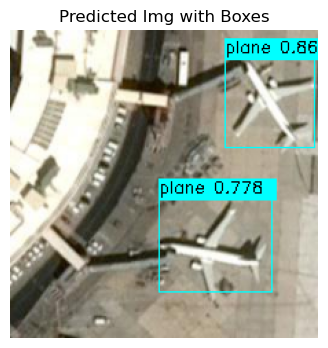

In [758]:
img_ds = cv2.resize(img, (IMG_W, IMG_H))

img_pred_boxes = plot_pytorch(ds_img=img_ds, 
                       img_w=img_ds.shape[1], 
                       img_h=img_ds.shape[0],
                       nms_preds=nms_pred)

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title("Predicted Img with Boxes")
ax.imshow(img_pred_boxes)
ax.set_axis_off()
plt.show()

# Original VS Precited

In [759]:
ori_resized = cv2.resize(img_boxes, (IMG_W, IMG_H))

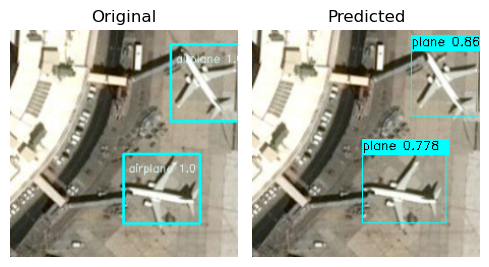

In [760]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 4))

plt.subplot(1, 2, 1)
ax1.set_title("Original")
ax1.imshow(ori_resized)
ax1.set_axis_off()

plt.subplot(1, 2, 2)
ax2.set_title("Predicted")
ax2.imshow(img_pred_boxes)
ax2.set_axis_off()

plt.tight_layout()
plt.show()